# SDSC3006 Group Project


## Steel Plates Faults Dataset (27 attributes, 1941 instances)


### Loading library


In [1]:
# Dev lib
# library(diffobj)


In [2]:
# Prod  lib
# suppressPackageStartupMessages({
library(repr)
library(ggplot2)
library(cowplot)
library(reshape2)
library(pROC)
library(caret)
library(e1071)

# library(factoextra)
# library(haven)
# library(rpart)
# library(rpart.plot)
# })


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice



### Supporting functions 

In [3]:
setPlotSize <- function(wRatio, hRatio) {
    options(repr.plot.width = wRatio * repr_option_defaults$repr.plot.width)
    options(repr.plot.height = hRatio * repr_option_defaults$repr.plot.height)
}


In [4]:
plotCM2Heatmap <- function(table) {
    ggplot(data = melt(table), aes(x = Prediction, y = Reference, fill = value)) +
        geom_tile(color = "black") +
        geom_text(aes(label = value)) +
        scale_fill_gradientn(colours = heat.colors(100, rev = TRUE)) +
        coord_fixed() +
        theme_grey(base_size = 14) +
        theme(axis.text.x = element_text(angle = 315, hjust = 0))
}


In [5]:
plotMultiRoc <- function(prediction, predictor, arrow) {
    set.seed(0)
    auc <- multiclass.roc(prediction, predictor, direction = arrow)
    for (i in 1:length(auc$rocs)) {
        plot.roc(auc$rocs[[i]], add = (if (i == 1) F else T), legacy.axes = T, lwd = 2, col = sample.int(100))
    }
}


### Set random seed


In [6]:
seed <- 0
print(seed)


[1] 0


### Load dataset


In [7]:
df <- read.table("Faults.NNA", col.names = as.vector(read.table("Faults27x7_var")$V1))
df.X <- scale(df[1:27])
df.Y <- data.frame(Faults = factor(names(df[28:34])[max.col(df[28:34])]))


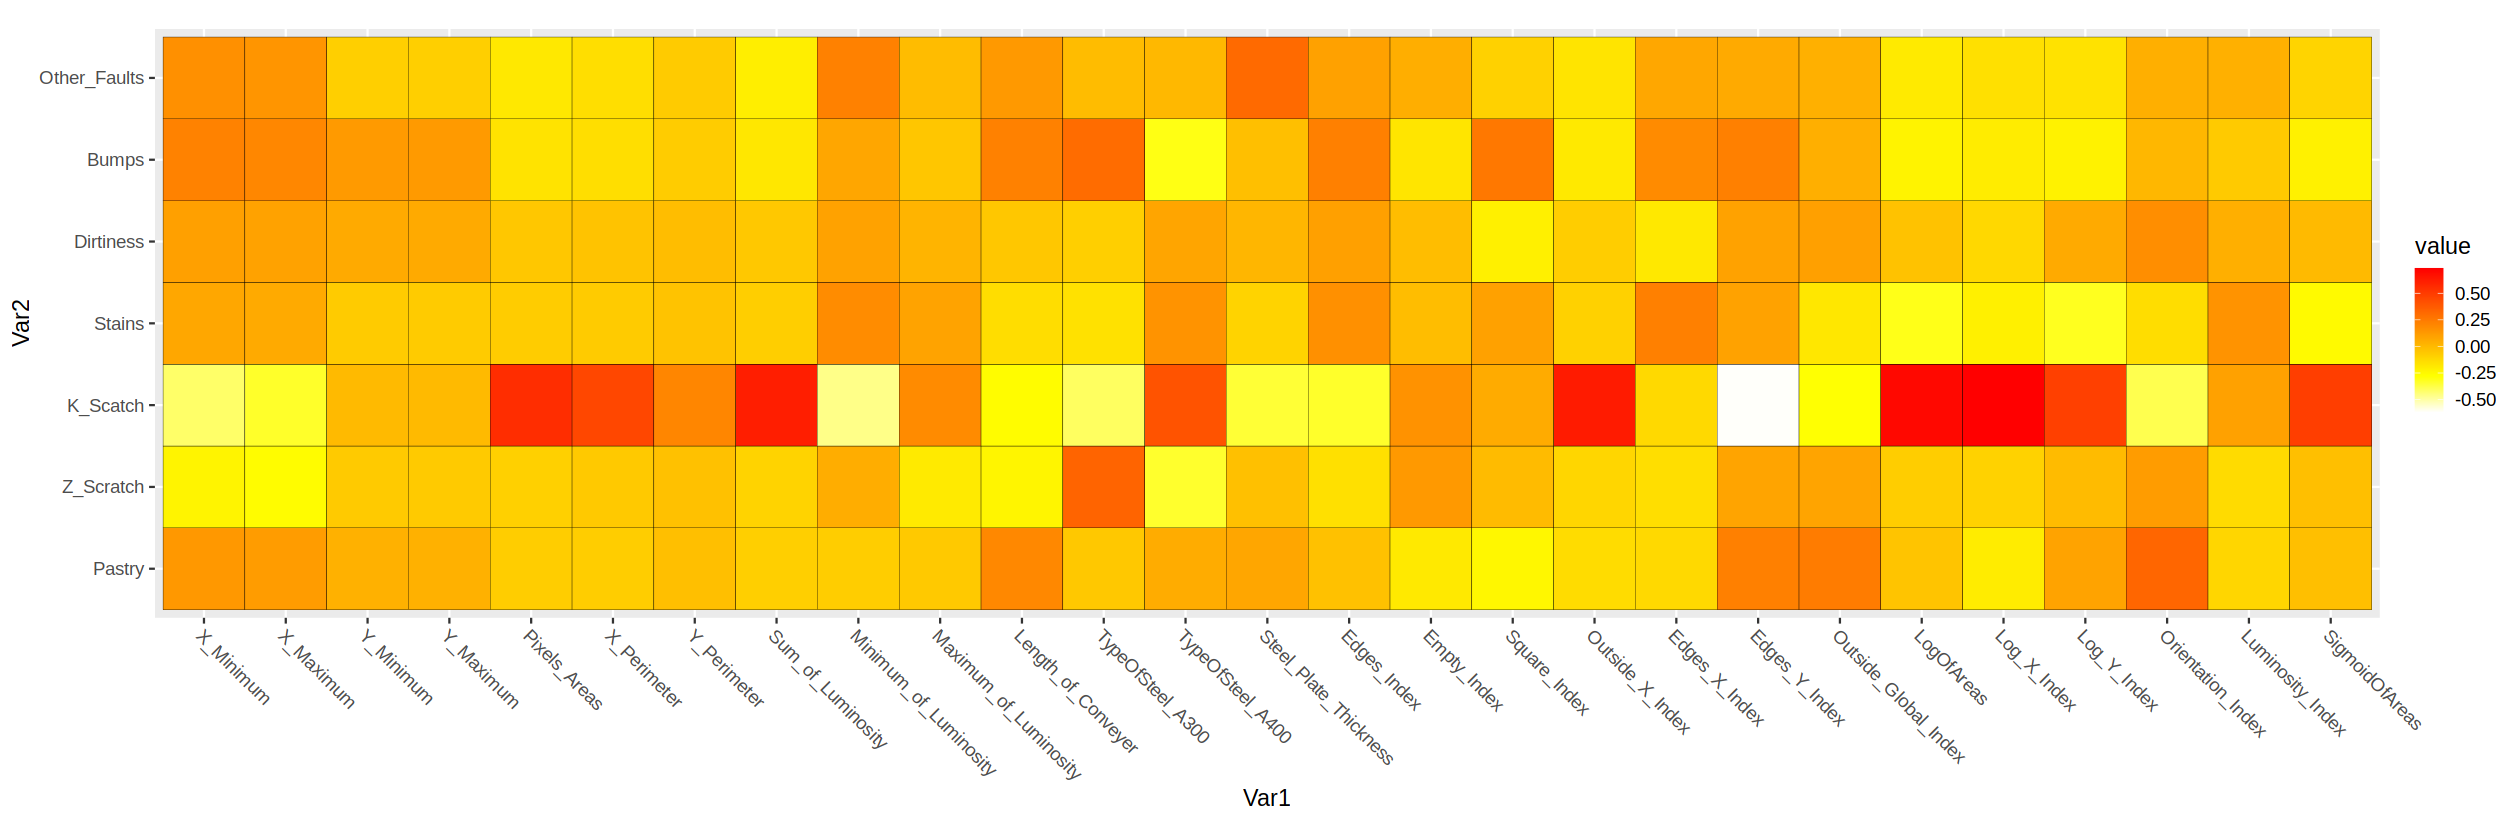

In [8]:
setPlotSize(3, 1)
ggplot(data = melt(cor(df.X, df[28:34])), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile(color = "black") +
    scale_fill_gradientn(colours = heat.colors(100, rev = TRUE)) +
    coord_fixed() +
    theme_grey(base_size = 14) +
    theme(axis.text.x = element_text(angle = 315, hjust = 0))


In [9]:
setPlotSize(1, 1)


### PCA Tranformation


In [10]:
df.pca <- prcomp(df[, -length(df)], scale = TRUE)
df.pcaX <- df.pca$x


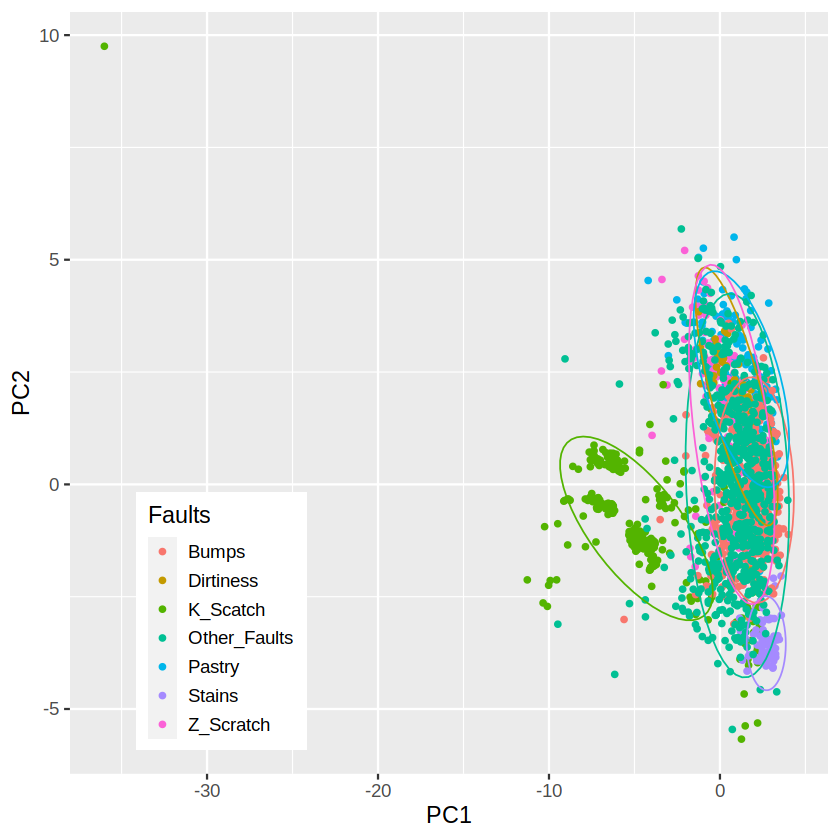

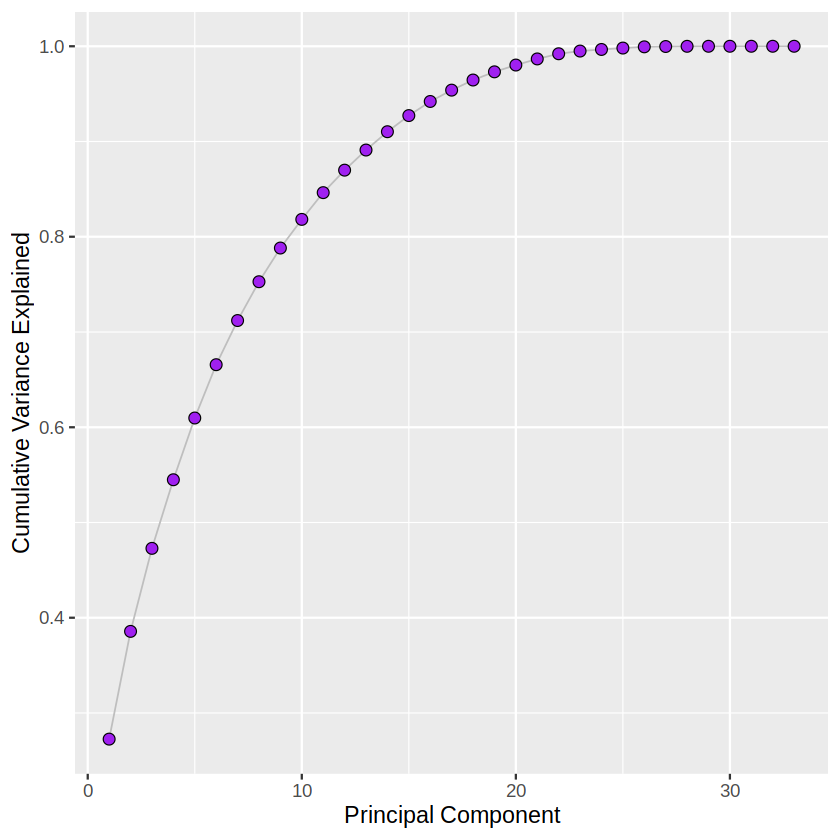

In [11]:
ggplot(cbind(df.pcaX, df.Y), aes(x = PC1, y = PC2, color = Faults)) +
    geom_point() +
    stat_ellipse(level = 0.95, show.legend = F) +
    theme_grey(base_size = 14) +
    theme(legend.position = c(0.2, 0.2))

impt <- melt(summary(df.pca)$importance[3, ])
ggplot(cbind(key = 1:nrow(impt), impt), aes(x = key, y = value, group = 1)) +
    geom_line(color="grey") +
    geom_point(shape=21, color="black", fill="purple", size=3) +
    theme_grey(base_size = 14) +
    xlab("Principal Component") +
    ylab("Cumulative Variance Explained")


### Split dataset


In [12]:
set.seed(seed)
rand <- sample(nrow(df), nrow(df) * 0.8)

df.train.X <- df.X[rand, ]
df.train.Y <- df.Y[rand, ]
df.train.pcaX <- df.pcaX[rand, ]

df.test.X <- df.X[-rand, ]
df.test.Y <- df.Y[-rand, ]
df.test.pcaX <- df.pcaX[-rand, ]


In [13]:
df.train <- data.frame(df.train.X, Faults=df.train.Y)
df.test <- data.frame(df.test.X, Faults=df.test.Y)
df.train.pca <- data.frame(df.train.pcaX, Faults=df.train.Y)
df.test.pca <- data.frame(df.test.pcaX, Faults=df.test.Y)


## Classifier

### SVM Linear


#### Without PCA


In [14]:
set.seed(seed)
svm.model <- tune(svm, df.train.X, df.train.Y, kernel = "linear", ranges = list(cost = 2^seq(-5, 5, 1)))
svm.train.yPred <- predict(svm.model$best.model, df.train.X)
svm.test.yPred <- predict(svm.model$best.model, df.test.X)

svm.train.cm <- confusionMatrix(svm.train.yPred, df.train.Y)
svm.test.cm <- confusionMatrix(svm.test.yPred, df.test.Y)

svm.train.cm$overall["Accuracy"]
svm.test.cm$overall["Accuracy"]


Accuracy 
    0.75

Accuracy 
0.7326478

In [15]:
summary(svm.model$best.model)



Call:
best.tune(METHOD = svm, train.x = df.train.X, train.y = df.train.Y, 
    ranges = list(cost = 2^seq(-5, 5, 1)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  2 

Number of Support Vectors:  934

 ( 380 268 52 114 69 17 34 )


Number of Classes:  7 

Levels: 
 Bumps Dirtiness K_Scatch Other_Faults Pastry Stains Z_Scratch




##### Confusion Matrix Heat map and Area under Curve


In [16]:
# plotMultiRoc(svm.test.yPred, as.numeric(df.test.Y), "<")


In [17]:
# plotCM2Heatmap(svm.test.cm$table)


#### With PCA


In [18]:
# set.seed(seed)
# svm.pca <- tune(svm, df.train.pcaX, df.train.Y, kernel = "poly", ranges = list(cost = seq(0, 10^1, 0.1)[-1]))
# svm.train.yPredPca <- predict(svm.pca$best.model, df.train.pcaX)
# svm.test.yPredPca <- predict(svm.pca$best.model, df.test.pcaX)

# svm.train.cmPca <- confusionMatrix(svm.train.yPredPca, df.train.Y)
# svm.test.cmPca <- confusionMatrix(svm.test.yPredPca, df.test.Y)

# svm.train.cmPca$overall["Accuracy"]
# svm.test.cmPca$overall["Accuracy"]


In [19]:
# summary(svm.pca$best.model)


##### Confusion Matrix Heat map and Area under Curve


In [20]:
# plotMultiRoc(svm.test.yPredPca, as.numeric(df.test.Y), "<")


In [21]:
# plotCM2Heatmap(svm.test.cmPca$table)
